In [66]:
import json
from tld import get_fld
import csv
import os.path
import numpy as np
import matplotlib.pyplot as plt


In [20]:
page_load_time_desktop=[]
page_load_time_mobile=[]
num_requests_desktop=[]
num_requests_mobile=[]
num_third_parties_desktop=[]
num_third_parties_mobile=[]
num_trackers_domain_desktop=[]
num_trackers_domain_mobile=[]
num_trackers_ent_desktop=[]
num_trackers_ent_mobile=[]




In [21]:
#load the disconnect blocklist as top level domains
f = open('services.json') 
disconnect = json.load(f) 
disconnect=disconnect['categories']
disconnect_blocklist=[]
for entry in disconnect:
    domain_list=disconnect[entry]
    for item in domain_list:
        keys=item.keys()
        for key, value in item.items():
            for inner_key,inner_value in value.items():
                for element in inner_value:
                    if len(element)>1:
                        disconnect_blocklist.append(element)




In [22]:
f = open('domain_map.json') 
domain_map = json.load(f) 

In [23]:
def get_page_load_time(website):
    start_time=website['pageload_start_ts']
    end_time=website['pageload_end_ts']
    return end_time-start_time

In [24]:
def get_num_requests(website):
    return len(website['requests'])


In [25]:
def get_third_parties(website):
    third_party_domains=set()
    first_domain=website['domain']
    for req in website['requests']:
        req_domain=get_fld(req['request_url'])
        if (req_domain!=first_domain):
            third_party_domains.add(req_domain)
    third_party_domains=list(third_party_domains)
    return third_party_domains

In [26]:
def get_tracker_domains(third_party_list):
    tracker_domains=set()
    for item in third_party_list:
        if item in disconnect_blocklist:
            tracker_domains.add(item)
    tracker_domains_to_list=(list)(tracker_domains)
    return tracker_domains_to_list

In [27]:
def get_tracker_entity (tracker_name):
    if tracker_name in domain_map.keys():
        return domain_map[tracker_name]['entityName']
    else:
        return "not found"
        

In [50]:
urls=[]
tranco_rank=[]
with open('tranco-top-500-safe.csv') as file:
                data = csv.reader(file,delimiter=',')
                for url_data in data:
                    urls.append(url_data[1])
                    tranco_rank.append(url_data[0])
urls.remove("domain")
tranco_rank.remove("tranco_rank")

500


In [59]:
def get_crawl_data(type):
    for entry in urls:
        file_name=entry+'_'+type+'.json'
        if (os.path.exists(file_name)):
            current= open(file_name) 
            website_dict = json.load(current)
            page_load=get_page_load_time(website_dict)
            req_count=get_num_requests(website_dict)
            third_parties=get_third_parties(website_dict)
            tracker_entities=set()
            tracker_domains=get_tracker_domains(third_parties)
            for tracker in tracker_domains:
                tracker_entities.add(get_tracker_entity(tracker))
            tracker_entities=list(tracker_entities)
            if (type=='desktop'):
                page_load_time_desktop.append(page_load)
                num_requests_desktop.append(req_count)
                num_third_parties_desktop.append(len(third_parties))
                num_trackers_domain_desktop.append(len(tracker_domains))
                num_trackers_ent_desktop.append(len(tracker_entities))
            else: 
                page_load_time_mobile.append(page_load)
                num_requests_mobile.append(req_count)
                num_third_parties_mobile.append(len(third_parties))
                num_trackers_domain_mobile.append(len(tracker_domains))
                num_trackers_ent_mobile.append(len(tracker_entities))


In [69]:
def generate_box_plot(data_desktop,data_mobile,plot_name):
    data= [data_desktop, data_mobile]
    label = ['crawl desktop', 'crawl mobile']
    fig, (ax1) = plt.subplots(nrows=1, figsize=(9, 4))

    bplot = ax1.boxplot(data,
                    vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=label)  # will be used to label x-ticks
    colors = ['pink', 'lightblue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax1.yaxis.grid(True)
    ax1.set_xlabel('type')
    ax1.set_ylabel('Observed values')
    ax1.set_title(plot_name)

    plt.savefig(plot_name+'.png')
    plt.show()


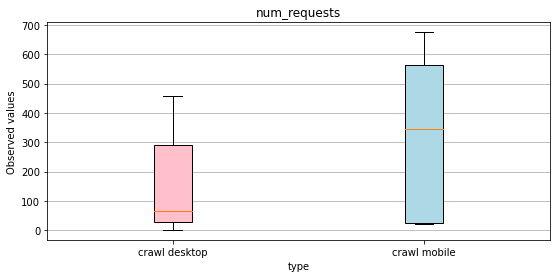

In [70]:
data_desktop = [234, 345, 22, 456, 1, 34, 67]
data_mobile =[23, 675, 564, 345, 22]
generate_box_plot(data_desktop,data_mobile,"num_requests")